# Generate transformation

# Read and Plot Transformation

# Daniel Code

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

In [15]:
# an interp function
def interp(x,I,phii,**kwargs):
   # note I want components of phi to be at the end
   # components of I should be at the beginning
   # this does make composing two transformations a bit weird
   # start by scaling to -1,1
   phii_ = torch.clone(phii)
   for i in range(3):
       phii_[...,i] -= x[i][0]
       phii_[...,i] /= x[i][-1]-x[i][0]
   phii_ *= 2.0
   phii_ -= 1.0

   # we need xyz at the end, and in the order xyz (not zyx)
   # check if I'm using batches
   if I.ndim == 4:
       add_batch = True
   elif I.ndim == 5:
       add_batch = False
   else:
       raise Exception('Image should be 4 or 5 dim')

   if add_batch:
       Iin = I[None]
       phii_in = phii_[None]
   else:
       Iin = I
       phii_in = phii_
   output = torch.nn.functional.grid_sample(Iin,
                                            torch.flip(phii_in,(-1,)),
                                            align_corners=True,padding_mode='border',**kwargs)
   # remove batch dimension
   if add_batch:
       output = output[0]
   return output

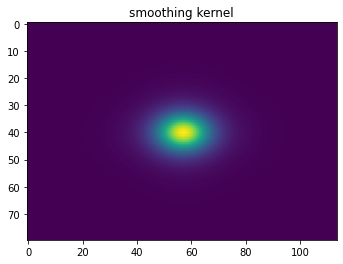

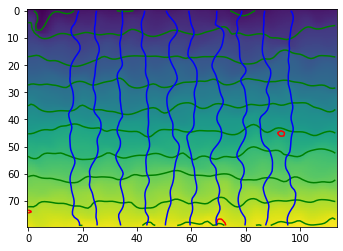

In [16]:
def expR(xv,v0,K,n=10,visualize=False,return_forward=True):
   '''
   Riemannian exponential, todo

   Parameters
   ----------
   xv : list of arrays
       Location of pixels in v.
   v : velocity at time 0
       Recall shape is rowxcolxsicex3
   K : array
       kernel in fft domain
   n : int
       number of timesteps

   visualie : bool
       only supported with no batch

   Returns
   -------
   phii : array
       inverse deformation used to transform images
   Notes
   -----
   pt = Dphi^{-T}(phi_t^{-1}) p0(phi_t^{-1})|Dphii^{-1}|
      = Dphii^{T} p0(phii)|Dphii^{-1}|
   '''

   use_batch = v0.ndim==5
   if not use_batch:
       permute0 = (-1,-4,-3,-2)
       permute1 = (-3,-2,-1,-4)
   else:
       permute0 = (0,-1,-4,-3,-2)
       permute1 = (0,-3,-2,-1,-4)


   # initialize p at time 0
   p0 = torch.fft.ifftn(torch.fft.fftn(v0,dim=(-2,-3,-4))/K[...,None],dim=(-2,-3,-4)).real
   # initialize phii at time 0
   XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)
   # initialize dv
   dv = [x[1].item() - x[0].item() for x in xv]

   phii = XV.clone()
   if use_batch:
       phii = phii[None].repeat(v0.shape[0],1,1,1,1)
       XV = XV[None].repeat(v0.shape[0],1,1,1,1)


   if visualize and not use_batch:
       fig,ax = plt.subplots(1,3)

   # we take n timesteps

   if return_forward:
       vsave = []
   for t in range(n):
       # we need to calculate p at time t
       # first we just deform it
       p = interp(xv,p0.permute(*permute0),phii).permute(*permute1)
       # then we need the jacobian
       Dphii = torch.stack(torch.gradient(phii,dim=(-4,-3,-2),spacing=dv),-1)
       # and the determinant (over the last two axes)
       detDphii = torch.linalg.det(Dphii)
       # then we will multiply

       p = (Dphii.transpose(-1,-2)@p[...,None])[...,0]*detDphii[...,None]
       # now we calculate v
       v = torch.fft.ifftn(torch.fft.fftn(p,dim=(-2,-3,-4))*K[...,None],dim=(-2,-3,-4)).real
       if return_forward:
           vsave.append(v)
       # now we update phii
       Xs = XV-v/n
       phii = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs

       if visualize and not use_batch:
           pshow = np.array(p[p0.shape[1]//2,:,:,:])
           pshow -= np.min(pshow,axis=(0,1,2))
           pshow /= np.max(pshow,axis=(0,1,2))
           ax[0].cla()
           ax[0].imshow(pshow)

           vshow = np.array(v[p0.shape[1]//2,:,:,:])
           vshow -= np.min(vshow,axis=(0,1,2))
           vshow /= np.max(vshow,axis=(0,1,2))
           ax[1].cla()
           ax[1].imshow(vshow)

           fig.canvas.draw()
   if not return_forward:
       return phii
   else:
       phi = XV.clone()
       for v in reversed(vsave):
           Xs = XV+v/n
           phi = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs
       return phi




# a domain for sampling your velocity and deformatoin
dv = np.array([5.0,5.0,5.0])
nv = np.array([132,80,114])
xv = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nv,dv)]
XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)

# a frequency domain
fv = [np.arange(n)/n/d for n,d in zip(nv,dv)]
FV = np.stack(np.meshgrid(*fv,indexing='ij'),-1)
a = 5.0
p = 2.0
LL = (1.0 - 2.0*a**2*np.sum(((np.cos(2.0*np.pi*FV*dv)   - 1))/dv**2,-1))**(2*p)
K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(np.fft.ifftshift(K[0]))
ax.set_title('smoothing kernel')


# lets make a new p which is really simple for testing
# sample white noise
Lm = np.random.randn(*FV.shape)*200

# smooth it with sqrt(K) (here I smoothed with K to be a bit smoother)
v = np.fft.ifftn(np.fft.fftn(Lm,axes=(0,1,2))*K[...,None],axes=(0,1,2)).real

#shoot it with remannian exponential
phii = expR([torch.tensor(x) for x in xv],torch.tensor(v),K,n=10)

fig,ax = plt.subplots()
levels = np.linspace(-200,200,10)
ax.imshow(phii[v.shape[0]//2,...,1])
ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,1],levels,colors='g',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,2],levels,colors='b',linestyles='-')

In [17]:
print("each unit is 20 microns")

each unit is 20 microns


# Modified

0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000
0 nans out of 1536000


KeyboardInterrupt: 

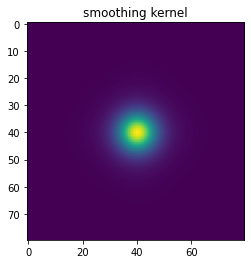

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def interp(points, values, xi):
    values = values.detach().cpu().numpy()
    xi = xi.detach().cpu().numpy()

    return torch.tensor(interpn(points, values, xi, bounds_error=False, fill_value=None))

def expR(xv,v0,K,n=10,visualize=False,return_forward=True):
    '''
    Riemannian exponential, todo

    Parameters
    ----------
    xv : list of arrays
        Location of pixels in v.
    v : velocity at time 0
        Recall shape is rowxcolxsicex3
    K : array
        kernel in fft domain
    n : int
        number of timesteps

    visualie : bool
        only supported with no batch

    Returns
    -------
    phii : array
        inverse deformation used to transform images
    Notes
    -----
    pt = Dphi^{-T}(phi_t^{-1}) p0(phi_t^{-1})|Dphii^{-1}|
        = Dphii^{T} p0(phii)|Dphii^{-1}|
    '''

    use_batch = v0.ndim==5
    if not use_batch:
        permute0 = (-4,-3,-2,-1)#(-1,-4,-3,-2)
        permute1 = (-4,-3,-2,-1)#(-3,-2,-1,-4)
    else:
        permute0 = (0,-1,-4,-3,-2)
        permute1 = (0,-3,-2,-1,-4)


    # initialize p at time 0
    p0 = torch.fft.ifftn(torch.fft.fftn(v0,dim=(-2,-3,-4))/K[...,None],dim=(-2,-3,-4)).real
    # initialize phii at time 0
    XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)
    # initialize dv
    dv = [x[1].item() - x[0].item() for x in xv]

    phii = XV.clone()
    if use_batch:
        phii = phii[None].repeat(v0.shape[0],1,1,1,1)
        XV = XV[None].repeat(v0.shape[0],1,1,1,1)


    if visualize and not use_batch:
        fig,ax = plt.subplots(1,3)

    # we take n timesteps

    if return_forward:
        vsave = []
    for t in range(n):
        # we need to calculate p at time t
        # first we just deform it
        p = interp(xv,p0.permute(*permute0),phii).permute(*permute1)
        # then we need the jacobian
        Dphii = torch.stack(torch.gradient(phii,dim=(-4,-3,-2),spacing=dv),-1)
        # and the determinant (over the last two axes)
        detDphii = torch.linalg.det(Dphii)
        # then we will multiply

        p = (Dphii.transpose(-1,-2)@p[...,None])[...,0]*detDphii[...,None]
        # now we calculate v
        v = torch.fft.ifftn(torch.fft.fftn(p,dim=(-2,-3,-4))*K[...,None],dim=(-2,-3,-4)).real
        if return_forward:
            vsave.append(v)
        # now we update phii
        Xs = XV-v/n
        phii = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs
        print(f"{torch.sum(torch.isnan(phii))} nans out of {np.product(phii.shape)}")
        
        if visualize and not use_batch:
            pshow = np.array(p[p0.shape[1]//2,:,:,:])
            pshow -= np.min(pshow,axis=(0,1,2))
            pshow /= np.max(pshow,axis=(0,1,2))
            ax[0].cla()
            ax[0].imshow(pshow)

            vshow = np.array(v[p0.shape[1]//2,:,:,:])
            vshow -= np.min(vshow,axis=(0,1,2))
            vshow /= np.max(vshow,axis=(0,1,2))
            ax[1].cla()
            ax[1].imshow(vshow)

            fig.canvas.draw()
    if not return_forward:
        return phii
    else:
        phi = XV.clone()
        for v in reversed(vsave):
            Xs = XV+v/n
            phi = interp(xv,(phii - XV).permute(*permute0),Xs).permute(*permute1) + Xs
        return phi




# a domain for sampling your velocity and deformatoin
dv = np.array([5.0,5.0,5.0])
nv = np.array([80,80,80])
xv = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nv,dv)]
XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)

# a frequency domain
fv = [np.arange(n)/n/d for n,d in zip(nv,dv)]
FV = np.stack(np.meshgrid(*fv,indexing='ij'),-1)
a = 5.0
p = 2.0
LL = (1.0 - 2.0*a**2*np.sum(((np.cos(2.0*np.pi*FV*dv)   - 1))/dv**2,-1))**(2*p)
K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(np.fft.ifftshift(K[0]))
ax.set_title('smoothing kernel')


# lets make a new p which is really simple for testing
# sample white noise
Lm = np.random.randn(*FV.shape)*90

# smooth it with sqrt(K) (here I smoothed with K to be a bit smoother)
v = np.fft.ifftn(np.fft.fftn(Lm,axes=(0,1,2))*K[...,None],axes=(0,1,2)).real

#shoot it with remannian exponential
phii = expR([torch.tensor(x) for x in xv],torch.tensor(v),K,n=10)

fig,ax = plt.subplots()
levels = np.linspace(-200,200,10)
ax.imshow(phii[v.shape[0]//2,...,1])
ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,1],levels,colors='g',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,2],levels,colors='b',linestyles='-')

# Plot transform

In [35]:
from scipy.spatial.distance import cosine
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    Diffeomorphism_Transform,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
import pandas as pd 
import seaborn as sns
import os 
from cloudvolume import CloudVolume
from pathlib import Path
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from copy import deepcopy
from tqdm import tqdm
from scipy.interpolate import splev, splprep, CubicHermiteSpline

In [19]:
phii = phii.detach().cpu().numpy()

root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

In [20]:
ct = Diffeomorphism_Transform(xv, phii)


average squared deformation 135.20993719995022
average 1-cosine between derivatives 0.02938904934703299


<mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x166603b50>

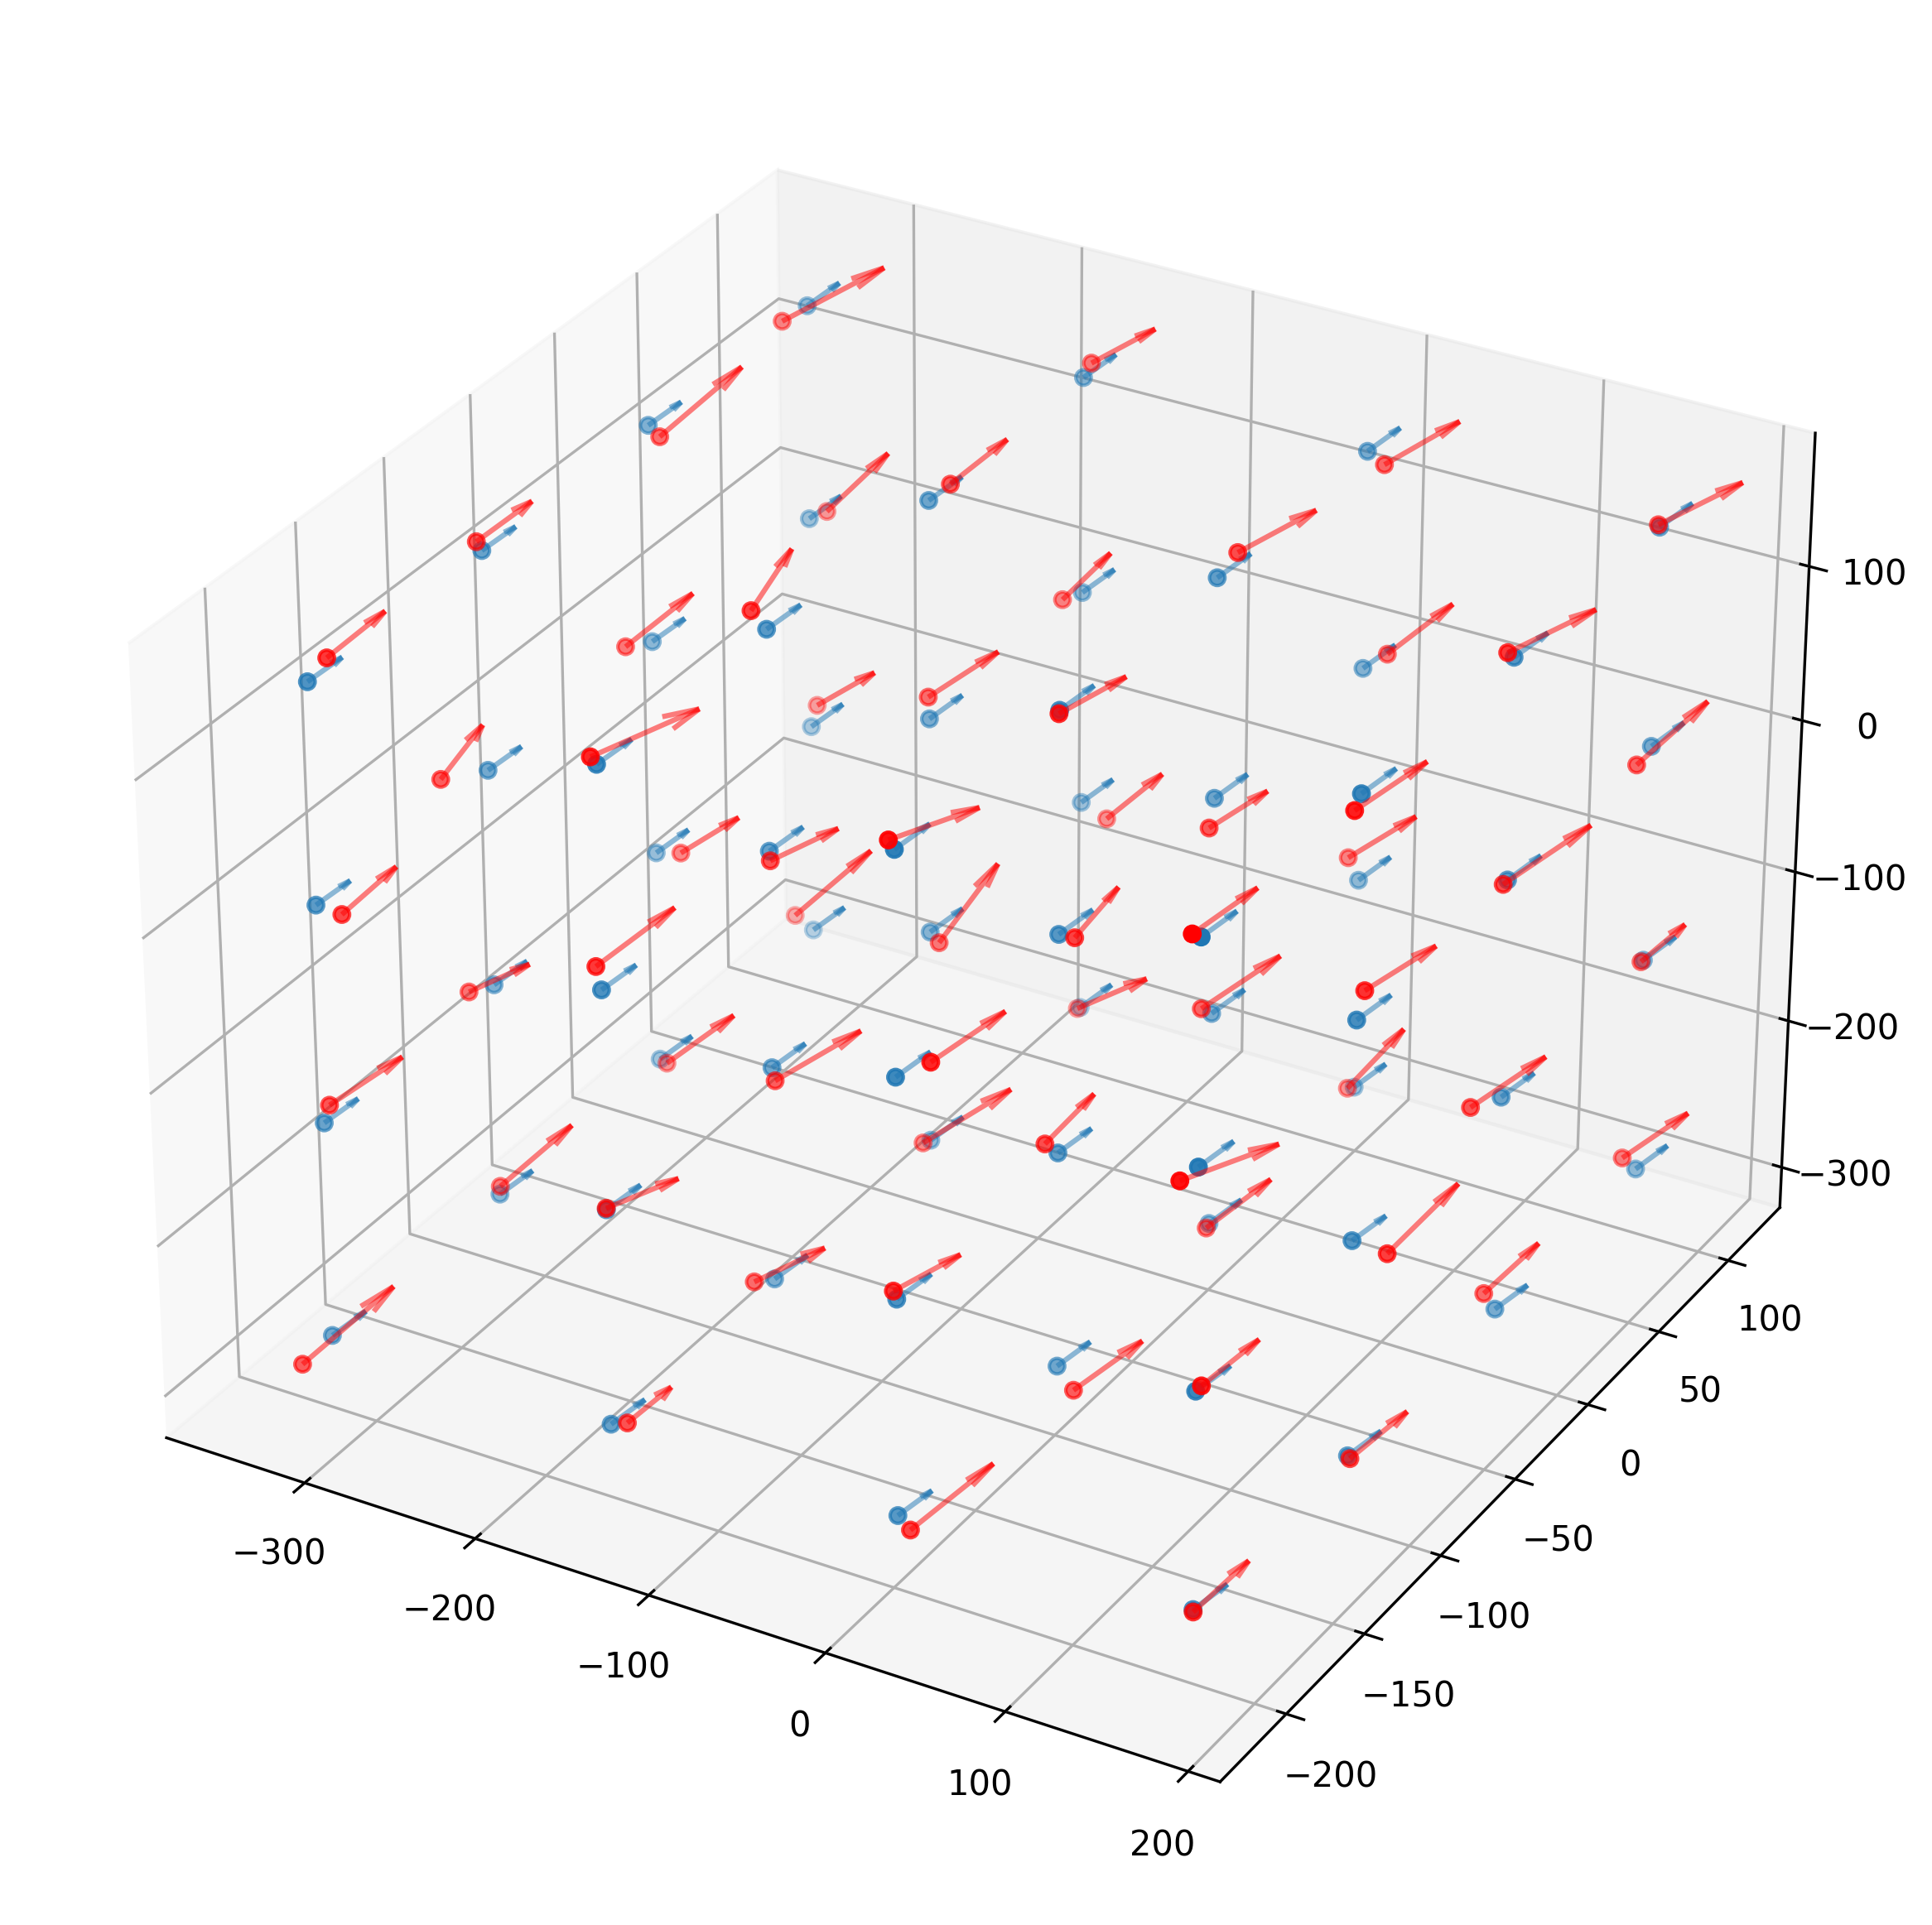

In [21]:
vlen = 10
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=vlen,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=vlen,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# # ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
# ax.legend(fontsize=17)

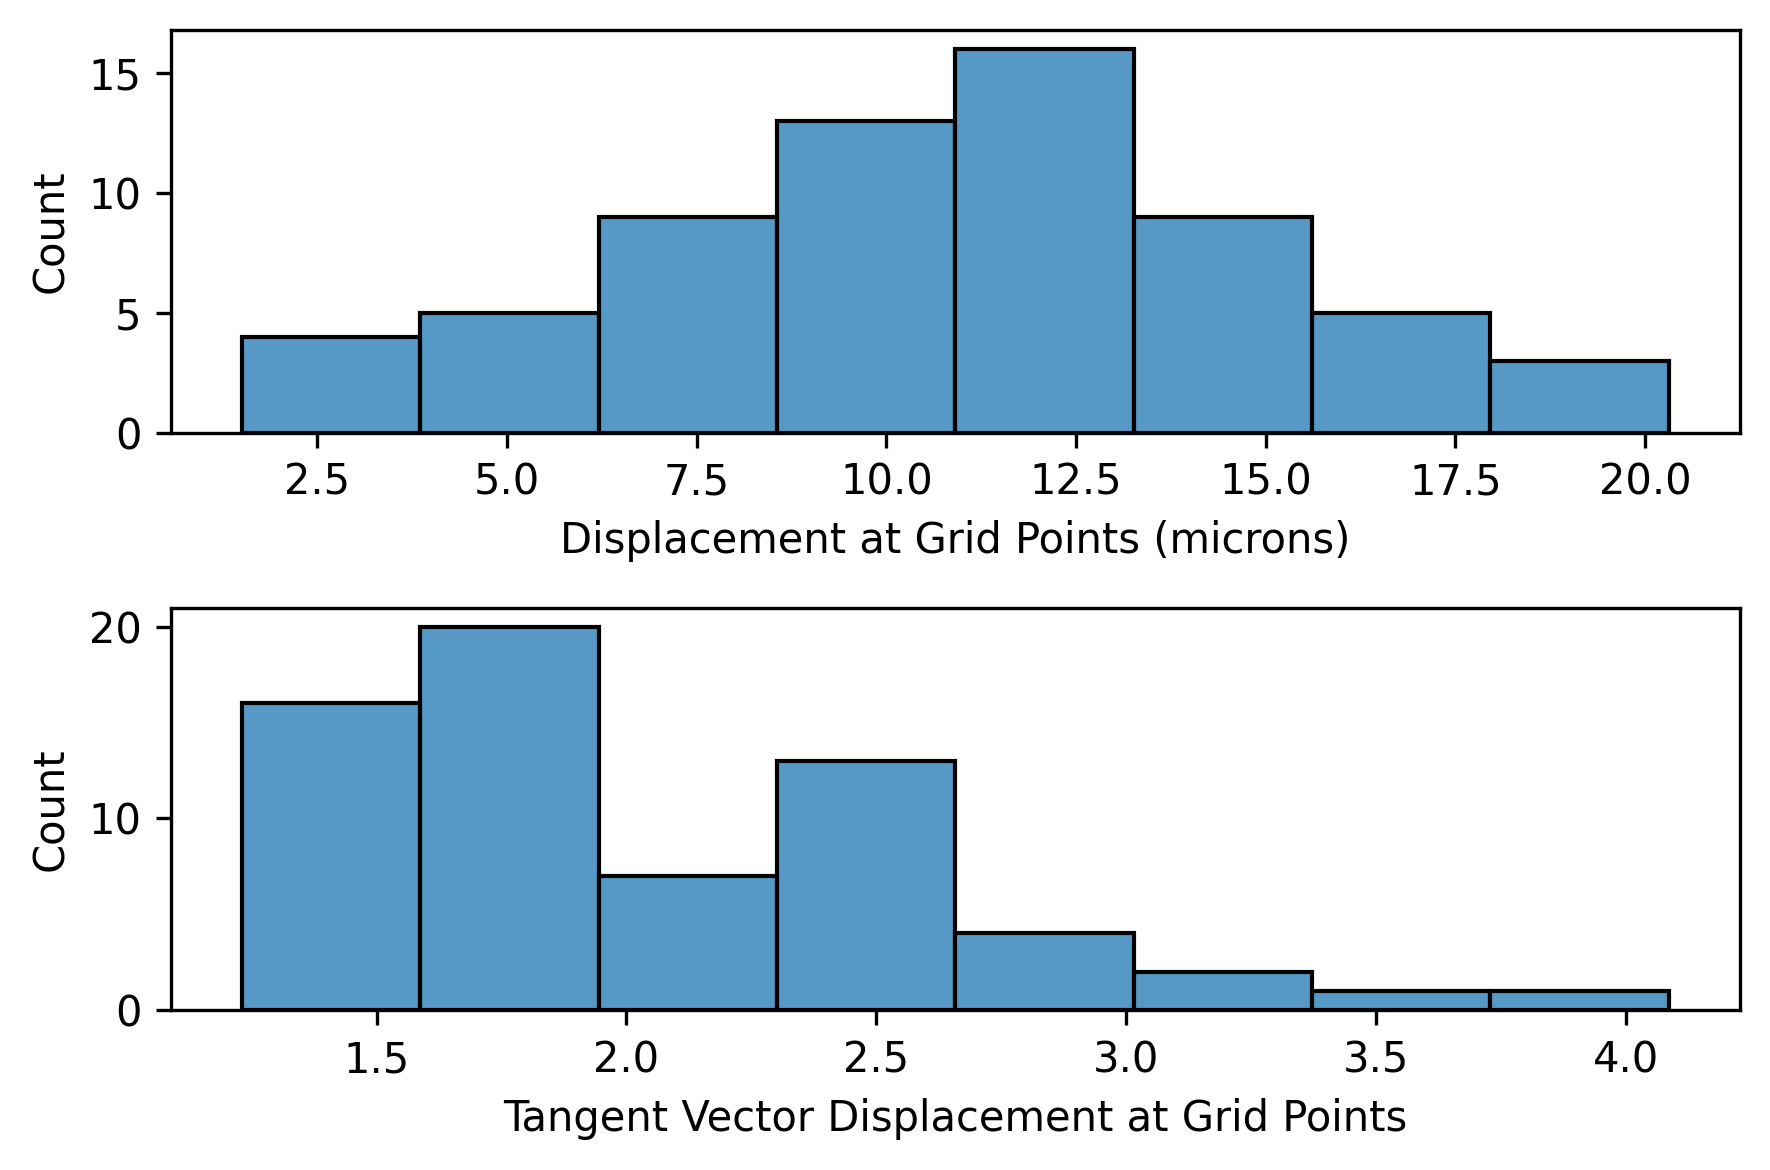

In [22]:
fig, axs = plt.subplots(2, dpi=300)
position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at Grid Points (microns)": position_diff,
    "Tangent Vector Displacement at Grid Points": deriv_diff,
}
df = pd.DataFrame(data=data)
sns.histplot(data=df, ax=axs[0], x="Displacement at Grid Points (microns)")
sns.histplot(data=df, ax=axs[1], x="Tangent Vector Displacement at Grid Points")
plt.tight_layout()

Target space: 100%|██████████| 183/183 [00:00<00:00, 127713.42it/s]


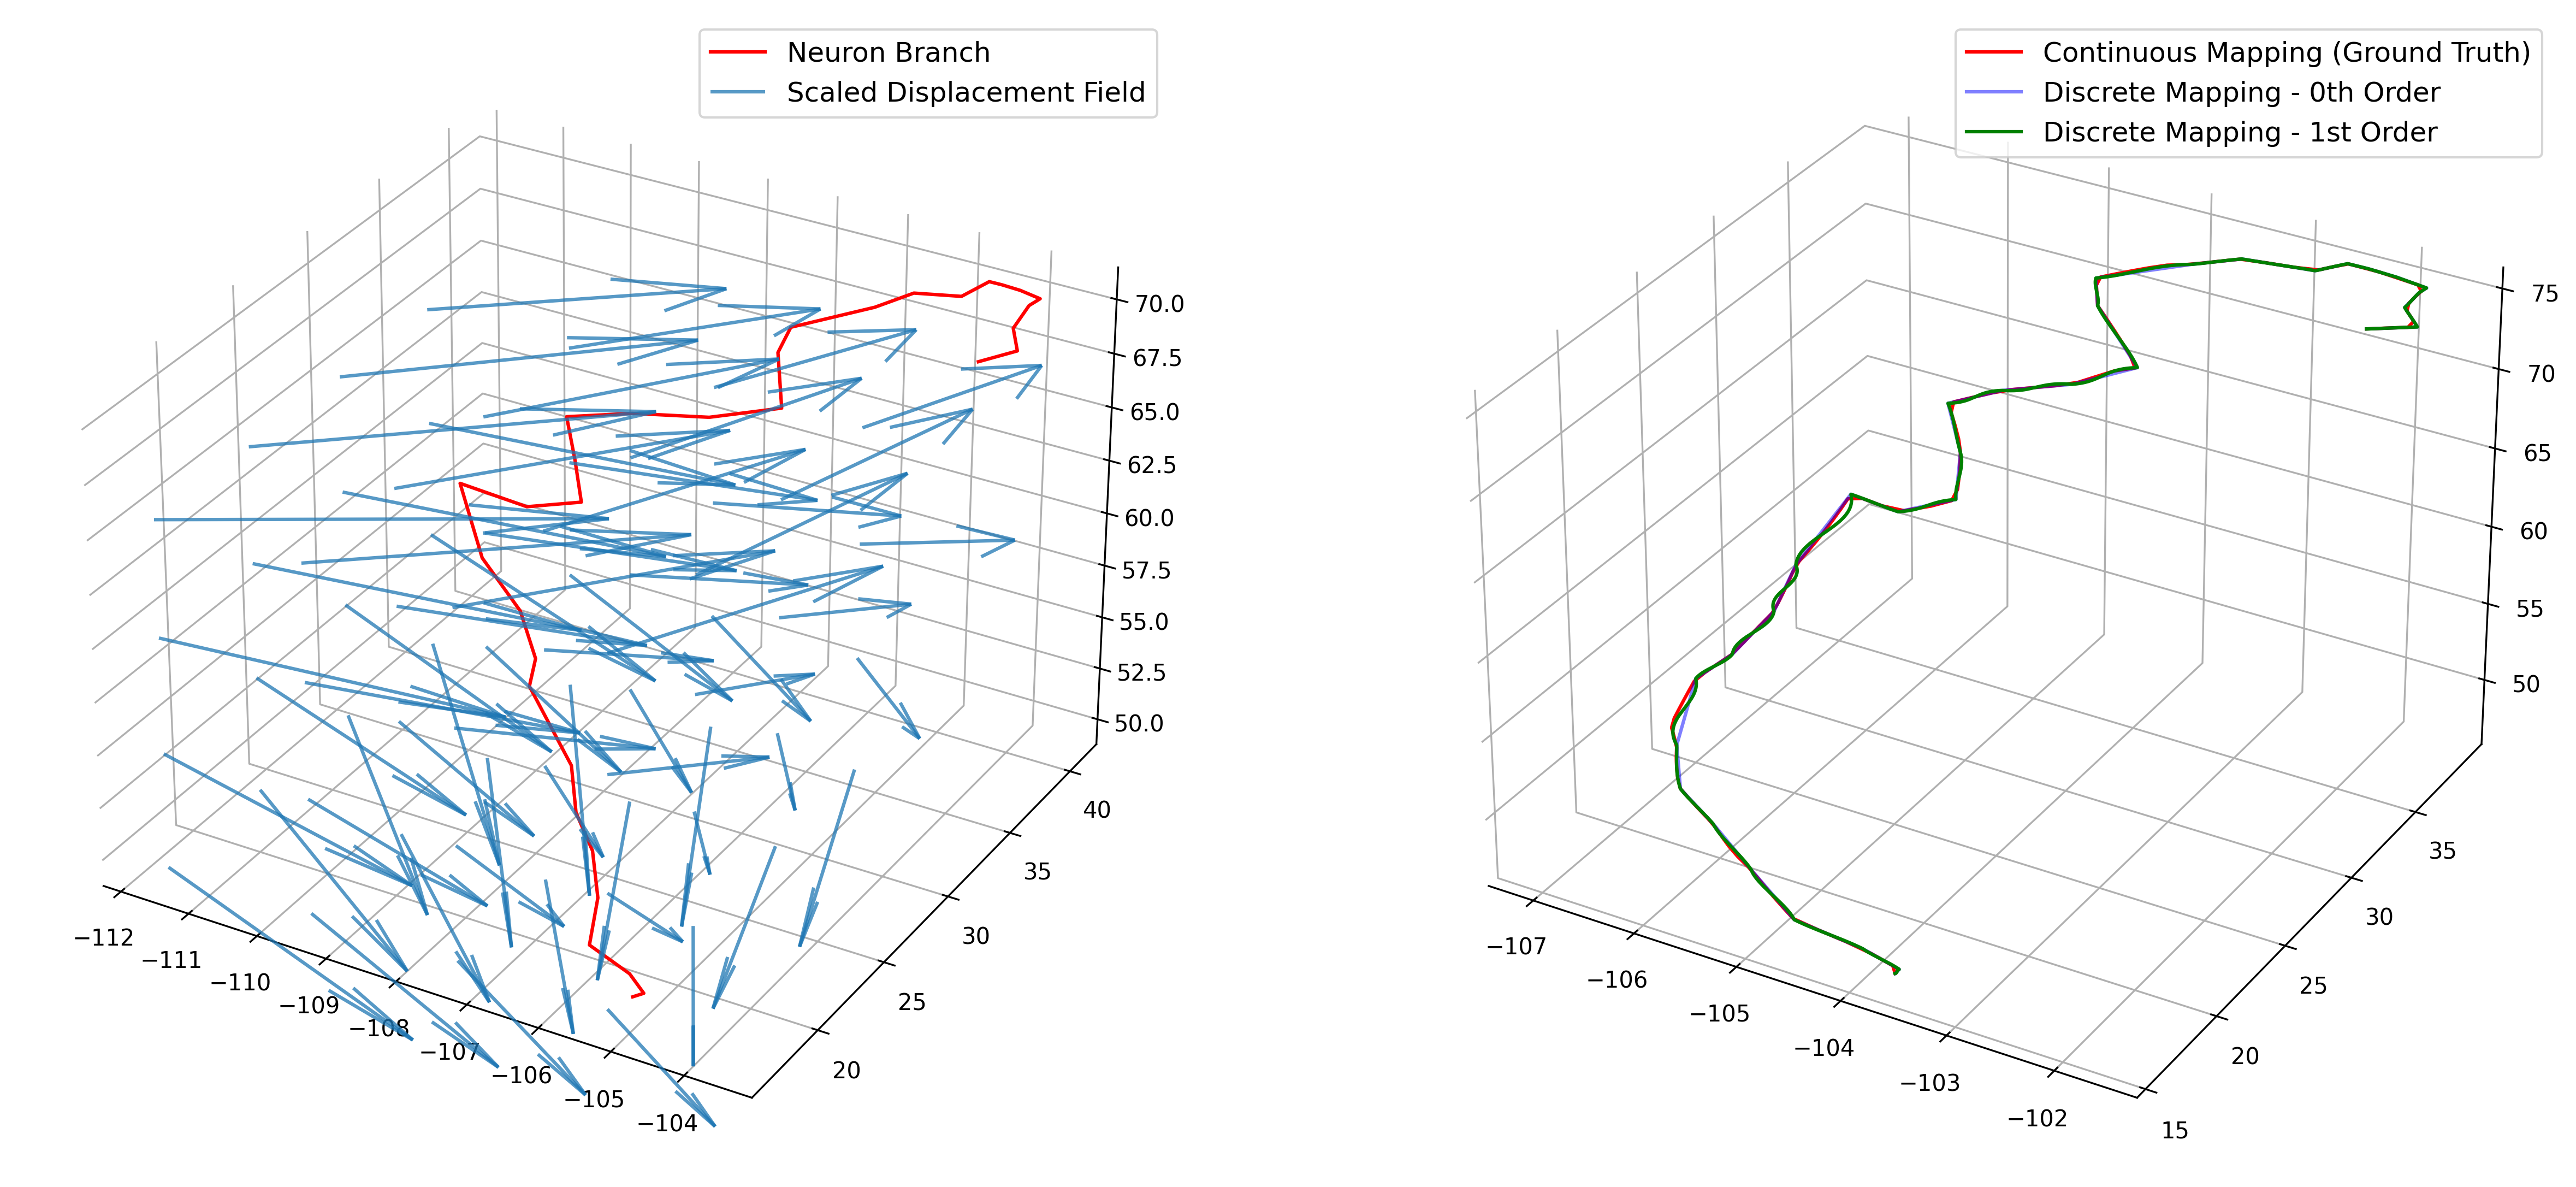

In [37]:
# 1,22; 4,179
neuron_id = 4
branch_id = 179

im_path = "precomputed://file://" + os.path.join(data_dir, "ch1_otsu_iso")
vol_im = CloudVolume(im_path)
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

axons_path = "precomputed://file://" + os.path.join(data_dir, "axons")
vol = CloudVolume(axons_path)
shp = np.array(vol.shape)
res_atlas = np.array(vol.resolution) / 1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/20

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)


# dense line points
tck_line, u_line = splprep(pts.T, k=1, s=0)
u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
pts_line = splev(u_line, tck_line)
pts_line = np.stack(pts_line, axis=1)
trans_pts = ct.evaluate(pts_line)

label = "Continuous Mapping (Ground Truth)"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    color="red",
    label=label,
)

# Transformed points
trans_pts = ct.evaluate(pts)
label = "Discrete Mapping - 0th Order"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    label=label,
    color="blue",
    alpha=0.5,
)
derivs = splev(u, tck, der=1)
derivs = np.stack(derivs, axis=1)
trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1] + 0.01, 0.01)
chspline = spline[0]
pts = chspline(u)

label = "Discrete Mapping - 1st Order"
ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

1st order mappings: 100%|██████████| 257/257 [00:00<00:00, 580.82it/s]


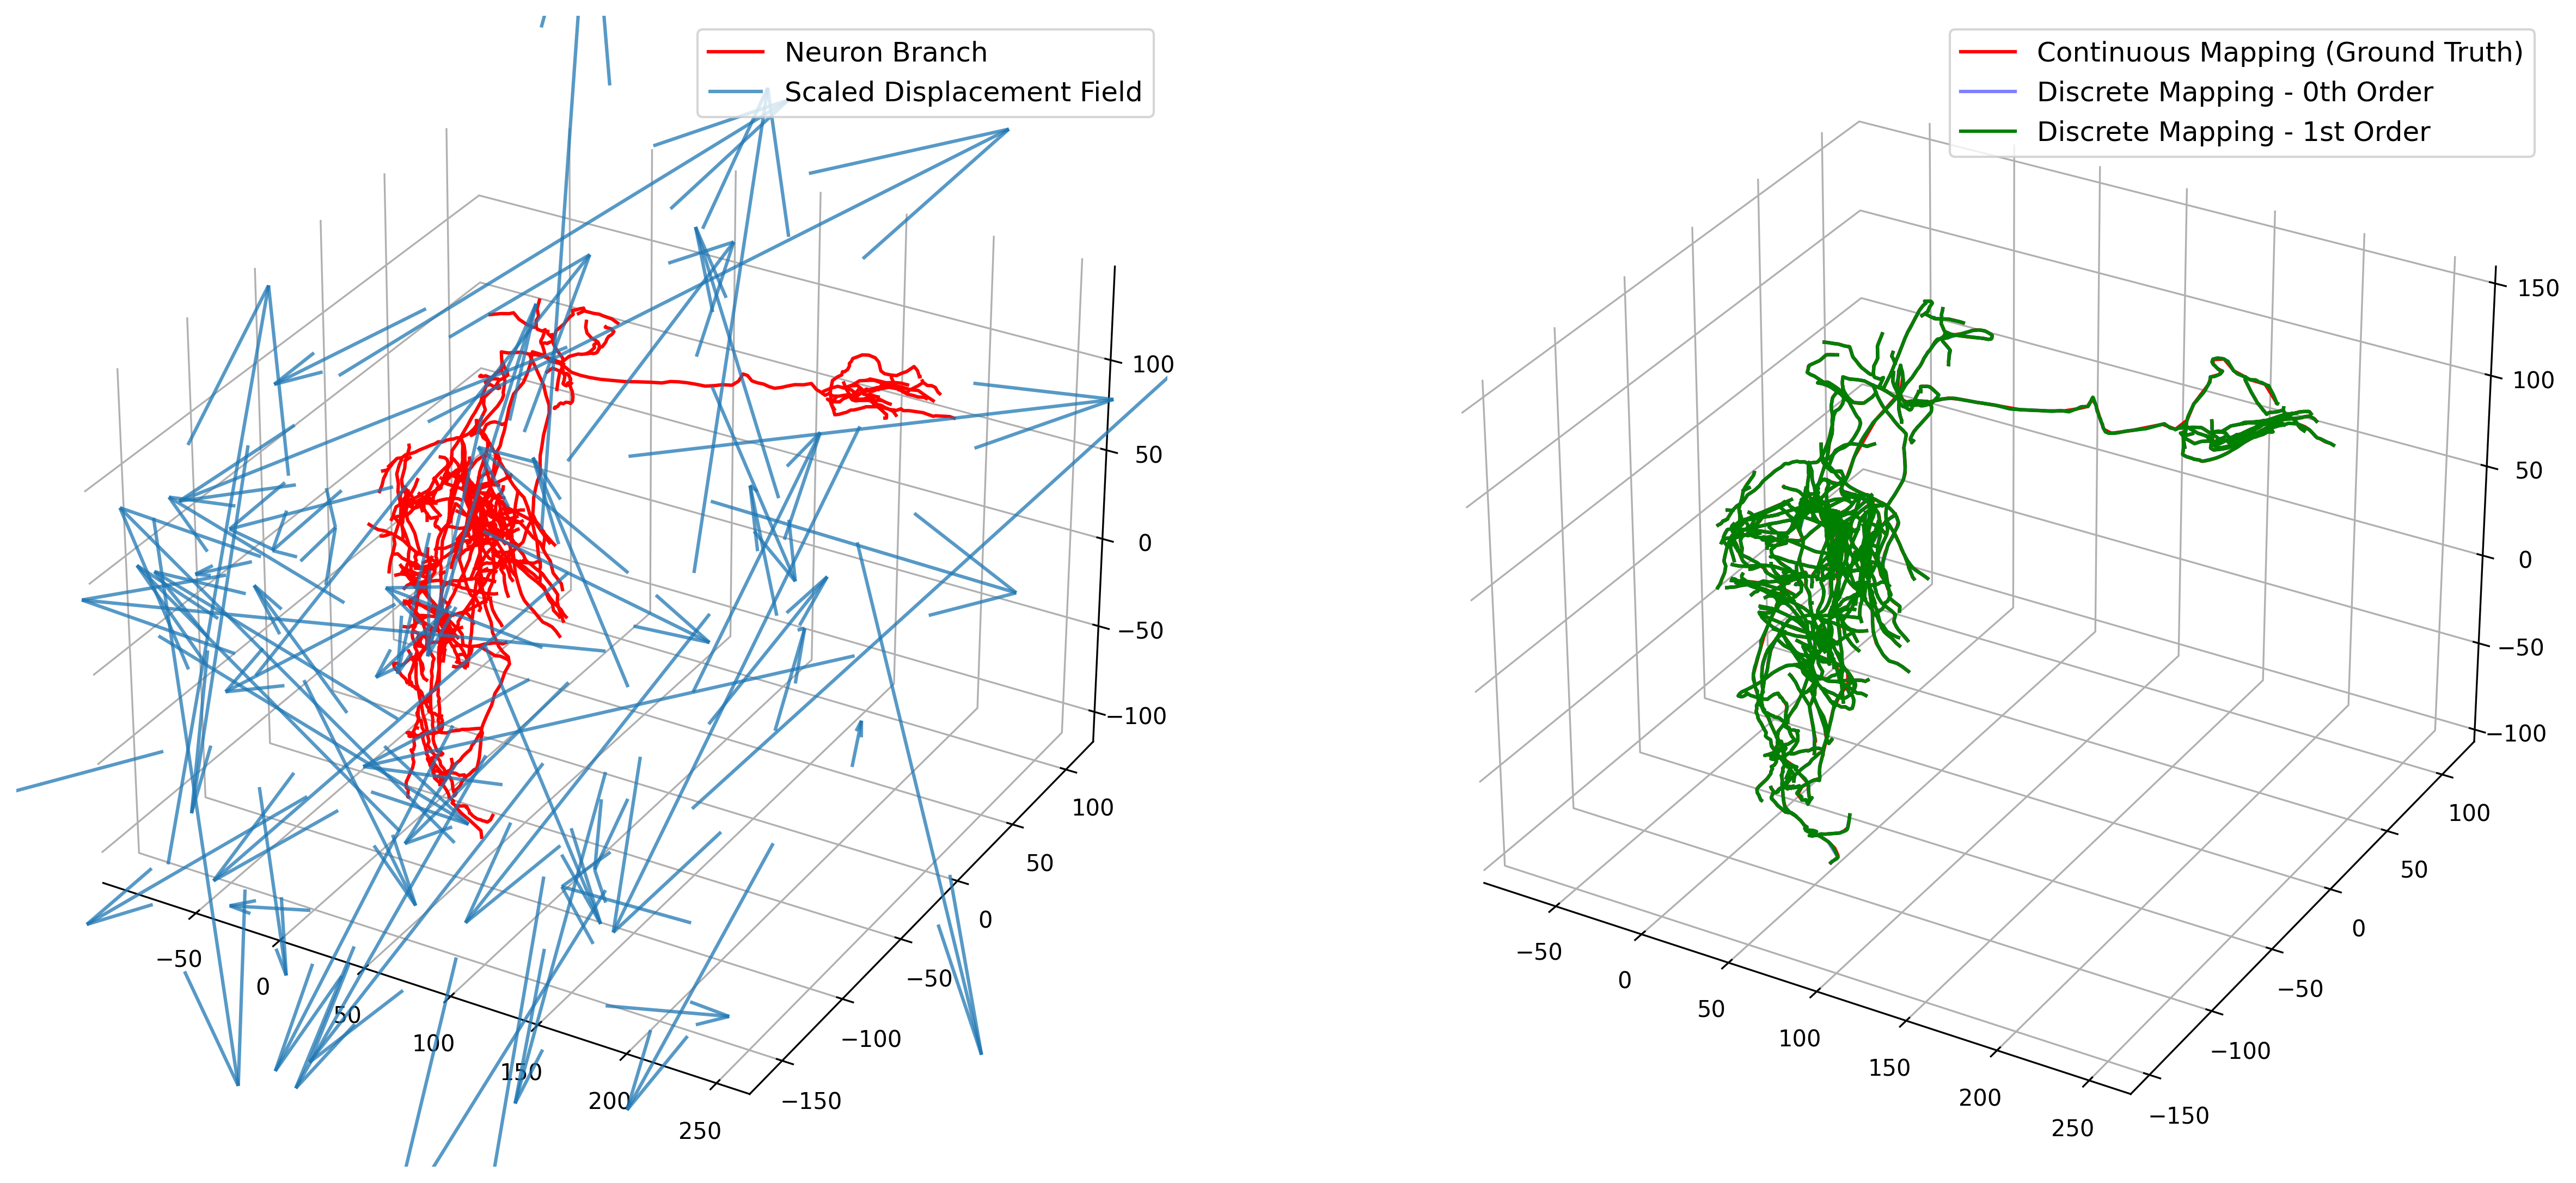

In [46]:
# 1,22; 4,179
neuron_id = 1
branch_id = -1

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/10

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

In [52]:
import pickle

with open("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/random-diffeo.pickle", 'wb') as f:
    pickle.dump(ct, f)

In [51]:
ct

<brainlit.map_neurons.map_neurons.Diffeomorphism_Transform object at 0x1387d3850>